In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
from lib.utils import get_phi_psi_dist, find_kdepeak, find_kdepeak_af, calc_da
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'tests'

# When computing da, which cluster is chosen based on:
a. Most Likely
b. X-Ray
c. AlphaFold

- If not most likely, is it usually second most likely?

In [139]:
proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from collections import defaultdict
bw_method = None
chosen_cluster = []
for protein in proteins:
    da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                           mode='kde_af')
    da.load_results()
    chosen_clusteri = defaultdict(list)
    print(len(da.xray_phi_psi))

    for seq in da.seqs:
        print(protein, seq)
        phi_psi_dist,info = get_phi_psi_dist(da.queries, seq)
        af = da.phi_psi_predictions[(da.phi_psi_predictions.protein_id == da.alphafold_id) & (da.phi_psi_predictions.seq_ctxt == seq)]
        xray = da.xray_phi_psi[da.xray_phi_psi.seq_ctxt == seq]
        if af.shape[0] == 0 or xray.shape[0] == 0:    
            print(f'Skipping {seq}')
            continue
        xray = xray[['phi', 'psi']].values[0]
        af = af[['phi', 'psi']].values[0]
        print(phi_psi_dist.shape)
        
        phi_psi_dist = phi_psi_dist.loc[~phi_psi_dist[['phi', 'psi']].isna().any(axis=1)]
        if phi_psi_dist.shape[0] < 4:
            print(f'Skipping {seq}')
            continue

        try:

            bandwidth = 100
            ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
            ms.fit(phi_psi_dist[['phi','psi']])
            phi_psi_dist['cluster'] = ms.labels_

            cluster_counts = phi_psi_dist.groupby('cluster').size()
            phi_psi_dist['cluster'] = phi_psi_dist['cluster'].apply(lambda x: x if cluster_counts[x] > 4 else -1)

            kdepeak = find_kdepeak(phi_psi_dist, bw_method)
            cluster_peaks = []
            probs = []
            for i in phi_psi_dist.cluster.unique():
                if i == -1:
                    continue
                kdepeak_c,prob = find_kdepeak(phi_psi_dist[phi_psi_dist.cluster == i], bw_method, return_prob=True)
                # print(prob, kdepeak_c.values)
                probs.append(prob)
                cluster_peaks.append(kdepeak_c.values)
            cluster_peaks = np.array(cluster_peaks)[np.argsort(probs)][::-1]
            probs = np.sort(probs)[::-1]
            # print(probs)
            # print(cluster_peaks)

            print(f'\tFound {len(cluster_peaks)} Clusters')

            # Choose peak that is closest to AlphaFold prediction
            dists = calc_da(af, cluster_peaks)
            argmin = dists.argmin()
            # print(argmin, cluster_peaks[argmin])
            chosen_clusteri['af'].append(argmin)
            chosen_clusteri['af_prob'].append(probs[argmin])

            # Choose peak that is closest toX-ray prediction
            dists = calc_da(xray, cluster_peaks)
            argmin = dists.argmin()
            chosen_clusteri['xray'].append(argmin)
            chosen_clusteri['xray_prob'].append(probs[argmin])

            # Choose peak that would be PDBMine prediction - highest prob
            chosen_clusteri['pdbmine'].append(0)
            chosen_clusteri['pdbmine_prob'].append(probs[0])
        except Exception as e:
            print(e)
    chosen_cluster.append(pd.DataFrame(chosen_clusteri).assign(protein=protein))
chosen_cluster = pd.concat(chosen_cluster)
chosen_cluster.to_csv('cluster_choice.csv', index=False)

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
396
T1024 GKEFWNL
Skipping GKEFWNL
T1024 KEFWNLD
(369, 5)
	Found 2 Clusters
T1024 EFWNLDK
(268, 5)
	Found 3 Clusters
T1024 FWNLDKN
(2362, 5)
	Found 2 Clusters
T1024 WNLDKNL
(2221, 5)
	Found 5 Clusters
T1024 NLDKNLQ
(3019, 5)
	Found 3 Clusters
T1024 LDKNLQL
(2552, 5)
	Found 1 Clusters
T1024 DKNLQLR
(1701, 5)
	Found 3 Clusters
T1024 KNLQLRL
(2776, 5)
	Found 4 Clusters
T1024 NLQLRLG
(2605, 5)
	Found 4 Clusters
T1024 LQLRLGI
(4215, 5)
	Found 4 Clusters
T1024 QLRLGIV
(3995, 5)
	Found 2 Clusters
T1024 LRLGIVF
(2942, 5)
	Found 5 Clusters
T1024 RLGIVFL
(1694, 5)
	Found 2 Clusters
T1024 LGIVFLG
(2032, 5)
	Found 2 Clusters
T1024 GIVFLGA
(4060, 5)
	Found 4 Clusters
T1024 IVFLGAF
(3729, 5)
	Found 4 Clusters
T1024 VFLGAFS
(3714, 5)
	Found 5 Clusters
T1024 FLGAFSY
(4049, 5)
	Found 3 Clusters
T1024 LGAFSYG
(1426, 5)
	Found 4 Clusters
T1024 GAFSYGT
(1806, 5)
	Found 3 Clusters
T1024 AFSYGTV
(1253

In [3]:
chosen_cluster = pd.read_csv('cluster_choice.csv')

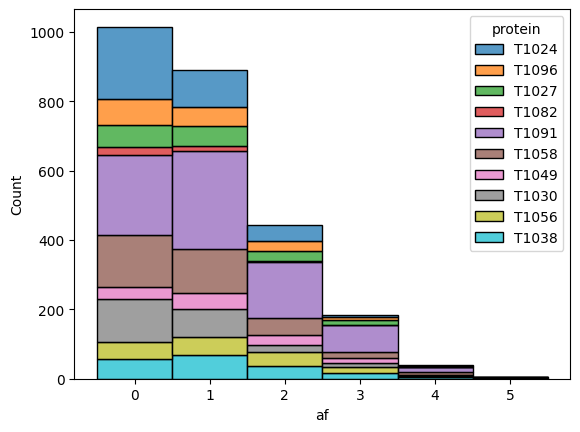

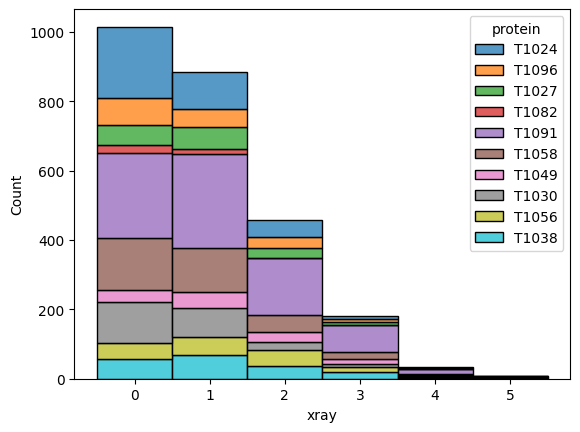

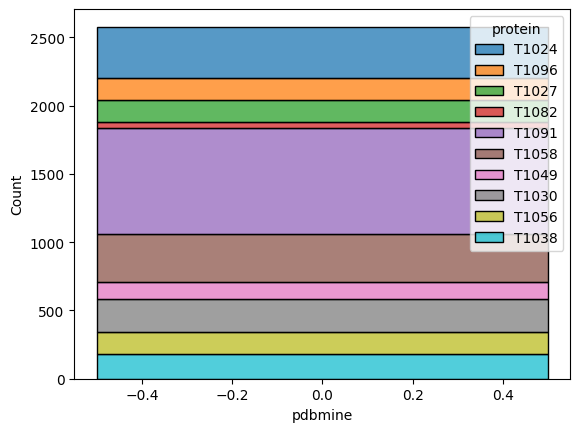

In [4]:
chosen_cluster['af'] = chosen_cluster.af.astype(int)
chosen_cluster['xray'] = chosen_cluster.xray.astype(int)
chosen_cluster['pdbmine'] = chosen_cluster.pdbmine.astype(int)
sns.histplot(data=chosen_cluster, x='af', discrete=True, hue='protein', multiple='stack')
plt.show()
sns.histplot(data=chosen_cluster, x='xray', discrete=True, hue='protein', multiple='stack')
plt.show()
sns.histplot(data=chosen_cluster, x='pdbmine', discrete=True, hue='protein', multiple='stack')
plt.show()

In [6]:
chosen_cluster.groupby('xray').size()

xray
0    1015
1     883
2     457
3     181
4      34
5       7
dtype: int64

Text(0.5, 1.0, 'Which Cluster is Chosen')

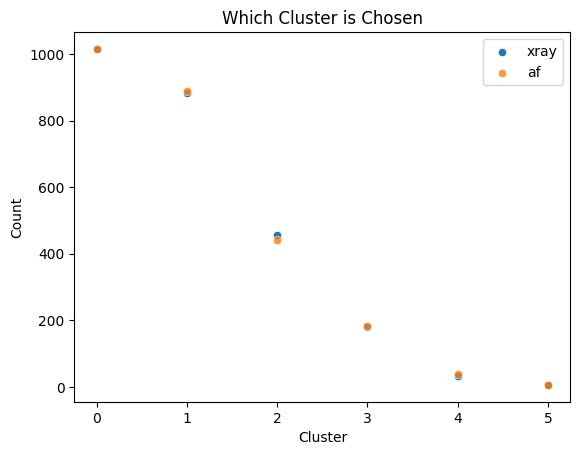

In [23]:
sns.scatterplot(data=chosen_cluster.groupby('xray').size().reset_index(), x='xray', y=0,label='xray')
sns.scatterplot(data=chosen_cluster.groupby('af').size().reset_index(), x='af', y=0, alpha=0.8,label='af')
plt.legend()
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Which Cluster is Chosen')
# df = pd.concat([chosen_cluster.groupby('xray').size().reset_index().rename(columns={0:'count', 'xray':'cluster'}), chosen_cluster.groupby('af').size().reset_index().rename(columns={0:'count', 'af':'cluster'})])
# sns.regplot(data=df, x='cluster', y='count', scatter=False)

In [30]:
chosen_cluster.groupby('xray').sum(numeric_only=True)[['af_prob']].reset_index()

,xray,af_prob
0,0,2.437654
1,1,0.980514
2,2,0.327386
3,3,0.103318
4,4,0.017433
5,5,0.003291


Text(0.5, 1.0, 'Which Cluster is Chosen')

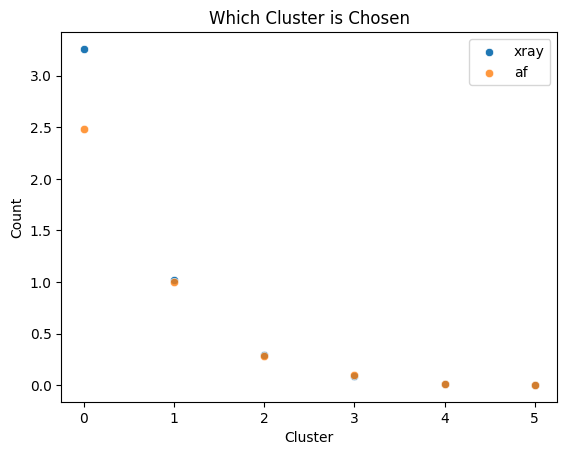

In [31]:
sns.scatterplot(data=chosen_cluster.groupby('xray').sum(numeric_only=True)[['xray_prob']].reset_index(), x='xray', y='xray_prob',label='xray')
sns.scatterplot(data=chosen_cluster.groupby('af').sum(numeric_only=True)[['af_prob']].reset_index(), x='af', y='af_prob', alpha=0.8,label='af')
plt.legend()
plt.xlabel('Cluster')
plt.ylabel('Total likelihood')
plt.title('Which Cluster is Chosen')
# df = pd.concat([chosen_cluster.groupby('xray').size().reset_index().rename(columns={0:'count', 'xray':'cluster'}), chosen_cluster.groupby('af').size().reset_index().rename(columns={0:'count', 'af':'cluster'})])
# sns.regplot(data=df, x='cluster', y='count', scatter=False)